# AML Homework 3

### Yue (Billy) Liu

## Question 1: Eigenface for face recognition

### (a) Download The Face Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy import misc
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import random

### (b) Load data in matrixs

(540, 2500) (540,)


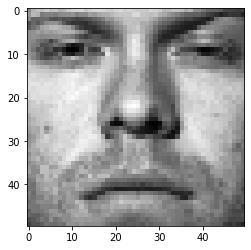

In [2]:
#Load traning set and display an image
train_labels, train_data = [], []
for line in open('./faces/train.txt'):
    im = misc.imread(line.strip().split()[0])
    train_data.append(im.reshape(2500,))
    train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

print (train_data.shape, train_labels.shape)

plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)

plt.show()

(100, 2500) (100,)


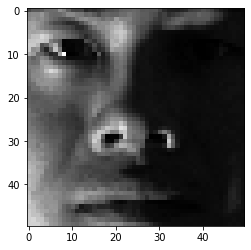

In [3]:
#Load test set and display an image
test_labels, test_data = [], []
for line in open('./faces/test.txt'):
    im = misc.imread(line.strip().split()[0])
    test_data.append(im.reshape(2500,))
    test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

print (test_data.shape, test_labels.shape)

plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)

plt.show()

### (c) Average Face

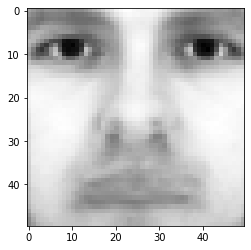

In [4]:
avg_Face = []
for i in range(2500):
    tmp = 0
    for row in train_data:
        tmp+=row[i]
    avg_Face.append(tmp/540)

avg_Face = np.array(avg_Face)

plt.imshow(avg_Face.reshape(50,50), cmap = cm.Greys_r)
plt.show()

### (d) Mean Subtraction

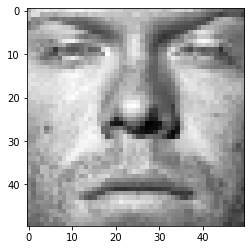

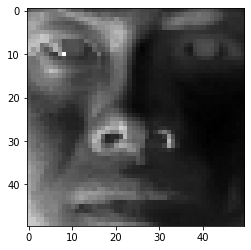

In [5]:
#Mean subtraction on training data
for row in train_data:
    row -= avg_Face
#mean subtraction on testing data   
for row in test_data:
    row -= avg_Face

#Displaying mean-subtracted training image
plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()
#Displaying mean-subtracted testing image
plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

### (e) Eigenface

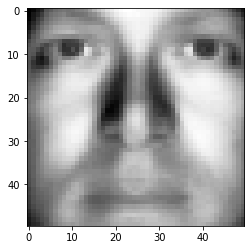

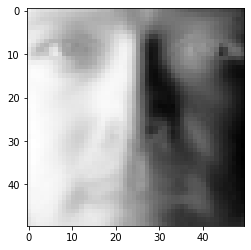

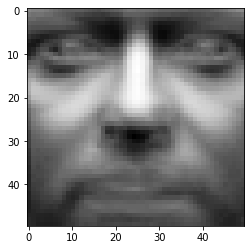

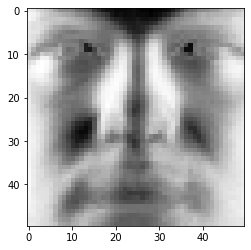

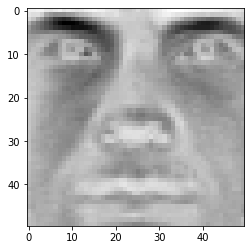

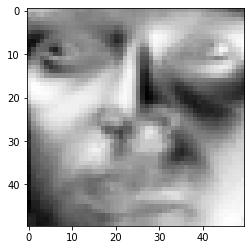

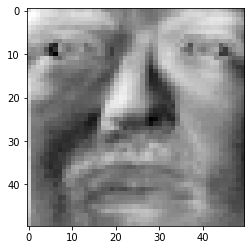

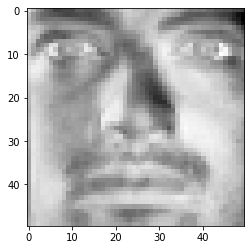

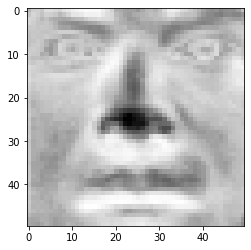

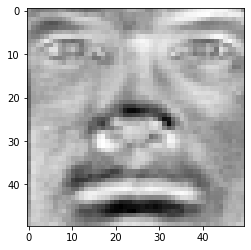

In [6]:
#eigen = np.dot(np.transpose(train_data),train_data)
def eigen_decomposition(X):
    Sigma = X.T.dot(X) / X.shape[0] # form covariance matrix
    eigen_val, eigen_vec = np.linalg.eig(Sigma) # perform eigendecomposition
    eigen_val = eigen_val.real
    eigen_vec = eigen_vec.real
    return eigen_val, eigen_vec

eigen_val, eigen_vec = eigen_decomposition(train_data)

for i in range(10):
    plt.imshow(np.array([float(x) for x in eigen_vec.T[i]]).reshape(50,50), cmap = cm.Greys_r)
    plt.show()

### (f) Eigenface Feature

In [7]:
def feature_matrix_F (x,eigen_vec,r):
    vt = eigen_vec.T
    f = np.dot(x,vt[:r,:].T)
    
    return f

f = feature_matrix_F(train_data, eigen_vec, 10) #r = 10
f_test = feature_matrix_F(test_data, eigen_vec, 10) #r = 10

### (g) Face Recognition

In [8]:
logistic = LogisticRegression(multi_class='ovr')
model_ovr = logistic.fit(f,train_labels)
predict = model_ovr.predict(f_test)
print('Accuracy when r=10: ' + str(accuracy_score(predict, test_labels)))

acc_list = []
for i in range(1,201):
    f = feature_matrix_F(train_data, eigen_vec, i)
    f_test = feature_matrix_F(test_data, eigen_vec, i) 
    logistic = LogisticRegression(multi_class='ovr')
    model_ovr = logistic.fit(f,train_labels)
    predict = model_ovr.predict(f_test)
    acc_list.append(accuracy_score(predict, test_labels))


Accuracy when r=10: 0.8


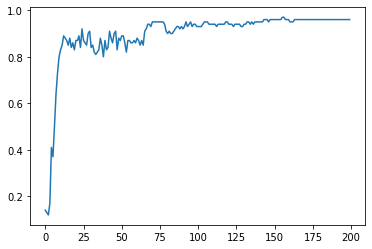

In [9]:
plt.plot(acc_list)

## Question 2: Implement EM Algorithm

### (a) Treat each data entry as a 2 dimensional feature vector. Parse and plot all data points on 2-D plane

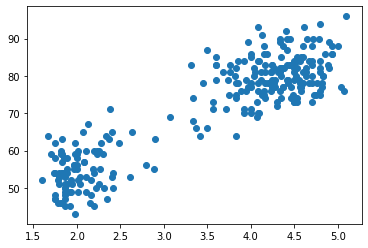

In [10]:
data = pd.read_csv('data.tsv', sep='\t')
plt.scatter(data.iloc[:,:-1],data.iloc[:,-1:])


### (b) Write the expression for Pθt (z = k | x)

### (c) Write down the formula for μk , Σk , and for the parameters φ at the M-step

### (d)

#### i. EM Implementation

In [43]:
class GMM:
    def __init__(self, k, max_iter=9999):
        self.k = k
        self.max_iter = int(max_iter)
        self.mu_list = []
        
    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.posterior = np.full(shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(X.T) for i in range(self.k)]
        
    def predict_proba(self, X):
        self.likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i])
            self.likelihood[:,i] = distribution.pdf(X)
        
        numerator = self.likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        posterior = numerator / denominator
        return posterior

    def e_step(self, X):
        # E-Step
        self.posterior = self.predict_proba(X)
        #Calculating phi
        self.phi = self.posterior.mean(axis=0)
    
    def m_step(self, X):
        # M-Step
        for i in range(self.k):
            weight = self.posterior[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0)/total_weight
            #convaraince of the dataset when each element  𝑥(𝑖)  has a weight  𝑃(𝑧=𝑘|𝑥(𝑖))
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)
            self.mu_list.append([])
            self.mu_list[i].append(self.mu[i])   

    def fit(self, X):
        self.initialize(X)
        self.e_step(X)
        self.m_step(X)
        last_likelihood = self.likelihood
        for iteration in range(1,self.max_iter):
            last_likelihood = self.likelihood
            self.e_step(X)
            self.m_step(X)
            if abs(sum(sum(self.likelihood))-sum(sum(last_likelihood)))<=1E-3:#Stopping Criterion
                break
                
        for mu in self.mu_list:
            tmpx = []
            tmpy = []
            for point in mu:
                tmpx.append(point[0])
                tmpy.append(point[1])
            plt.scatter(tmpx,tmpy)
    
    def predict(self, X):
        posterior = self.predict_proba(X)
        return np.argmax(posterior, axis=1)

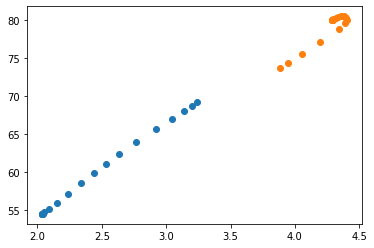

In [51]:
data = np.array(data)
model_GMM = GMM(k=2)
model = model_GMM.fit(data)

#### ii. State your termination criterion and explain the reasoning behind it

In [19]:
#I used the sum of posterior probabilities as termination criterion, if the sum of the probabilities compared to previous
#clustering is less than 1E-3, then the model probably isn't learning anything new so it will stop iterating in order 
#to preventing converging to local optimum points

#### iii. Plot the trajectories of the two mean vectors in 2 dimensiosn to show how they change over the course of runnign EM

In [20]:
#Drawn in part (i)

### (e) If you run K-means clustering instead of the EM algorithm you just implemented, do you think you will get different clusters?

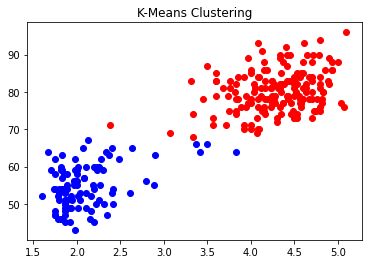

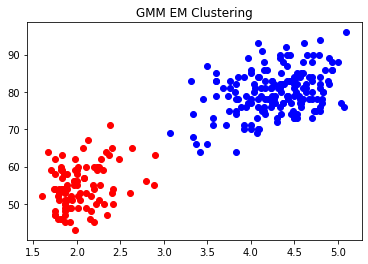

In [52]:
#Kmeans clusters
kmeans = KMeans(n_clusters=2, random_state=0)
label = kmeans.fit_predict(data)

label0 = data[label == 0]
label1 = data[label == 1]
plt.scatter(label0[:,0] , label0[:,1] , color = 'red')
plt.scatter(label1[:,0] , label1[:,1] , color = 'blue')
plt.title("K-Means Clustering")
plt.show()

#GMM clusters
prediction = model_GMM.predict(data)
data_copy = pd.read_csv('data.tsv', sep='\t')
data_copy.insert(2,'label',prediction,True)

label0 = data_copy.loc[data_copy['label'] == 0]
label1 = data_copy.loc[data_copy['label'] == 1]
plt.scatter(label0.iloc[:,0] , label0.iloc[:,1] , color = 'red')
plt.scatter(label1.iloc[:,0] , label1.iloc[:,1] , color = 'blue')
plt.title("GMM EM Clustering")
plt.show()

#From the two chart we observe some difference between to two clustering method. Clearly, the EM does a better job at
#dividing the two clusters.
